In [1]:
print('hello word')
print('i am studying rnn')
fname = "./frankenstein_dataset.json"
import json
# load
with open(fname, 'r') as f:
    data = json.load(f)
# print keys
print(data.keys())
# within data get sentence and next_word
sentence = []
next_word = []
for i in data['data']:
    sentence.append(i['sentence'])
    next_word.append(i['next_word'])
# conver to dataframe
import pandas as pd
df = pd.DataFrame({'sentence':sentence, 'next_word':next_word})
# split data into train and test
from sklearn.model_selection import train_test_split
# First split to separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['sentence'], df['next_word'], test_size=0.25, random_state=42)

# Second split to create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)  # 20% of 75% = 15% of the whole


hello word
i am studying rnn
dict_keys(['data'])


In [2]:
import torch
# Load GloVe Embeddings
glove_file = "glove.6B.100d.txt"
glove_embeddings = {}
with open(glove_file, "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = torch.tensor([float(x) for x in values[1:]], dtype=torch.float32)
        glove_embeddings[word] = vector
import pandas as pd
from sklearn.metrics import f1_score

In [3]:
from torch.utils.data import Dataset, DataLoader
# Assuming glove_embeddings has been loaded as shown earlier
def sentence_to_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_embeddings.get(word, torch.zeros(100, dtype=torch.float32)) for word in words]
    return torch.stack(embeddings)

class SentenceDataset(Dataset):
    def __init__(self, df):
        self.df = df
        next_words = df["next_word"].tolist()
        self.word_to_idx = {word: i for i, word in enumerate(sorted(set(next_words)))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence = self.df.iloc[idx, 0]
        next_word = self.df.iloc[idx, 1]
        embedding = sentence_to_embedding(sentence)
        next_word_idx = self.word_to_idx[next_word]
        return {"sentence": embedding, "next_word": next_word_idx}

In [4]:
# turn X_train and X_test into dataframe
df_train = pd.DataFrame({'sentence':X_train, 'next_word':y_train})
dataset = SentenceDataset(df_train)
dataloader_train = DataLoader(dataset, batch_size=128, shuffle=True)

In [5]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        # hidden shape: [batch_size, hidden_dim]
        # encoder_outputs shape: [batch_size, seq_len, hidden_dim]
        seq_len = encoder_outputs.size(1)
        
        # Repeat hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Calculate attention scores
        energy = torch.tanh(self.Wa(hidden) + self.Ua(encoder_outputs))
        scores = self.Va(energy).squeeze(2)  # [batch_size, seq_len]
        
        # Convert scores to weights
        weights = F.softmax(scores, dim=1).unsqueeze(1)  # [batch_size, 1, seq_len]
        
        # Calculate context vector as the weighted sum of encoder outputs
        context = torch.bmm(weights, encoder_outputs).squeeze(1)  # [batch_size, hidden_dim]
        return context, weights

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        
        # Pass the input through the LSTM
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Apply attention using the last hidden state and all outputs
        context, attn_weights = self.attention(hn[-1], lstm_out)
        
        # Dropout on context
        context = self.dropout(context)
        
        # Pass the context through the fully connected layer
        out = self.fc(context)
        return out, attn_weights  # Return attention weights for possible visualization or analysis

output_dim = len(dataset.word_to_idx)  # Number of unique next words
# Set up model, criterion, optimizer, and scheduler
model = LSTMModel(input_dim=100, hidden_dim=128, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Early stopping parameters
def calculate_perplexity(loss):
    return torch.exp(loss)
# Training Loop with Perplexity Calculation
n_epochs = 100

/opt/homebrew/anaconda3/envs/llm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print('hello word')
print('i am studying rnn')
fname = "./frankenstein_dataset.json"
import json
# load
with open(fname, 'r') as f:
    data = json.load(f)
# print keys
print(data.keys())
# within data get sentence and next_word
sentence = []
next_word = []
for i in data['data']:
    sentence.append(i['sentence'])
    next_word.append(i['next_word'])
# conver to dataframe
import pandas as pd
df = pd.DataFrame({'sentence':sentence, 'next_word':next_word})
# split data into train and test
from sklearn.model_selection import train_test_split
# First split to separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['sentence'], df['next_word'], test_size=0.25, random_state=42)

# Second split to create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)  # 20% of 75% = 15% of the whole

import torch
# Load GloVe Embeddings
glove_file = "glove.6B.100d.txt"
glove_embeddings = {}
with open(glove_file, "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = torch.tensor([float(x) for x in values[1:]], dtype=torch.float32)
        glove_embeddings[word] = vector
import pandas as pd
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
# Assuming glove_embeddings has been loaded as shown earlier
def sentence_to_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_embeddings.get(word, torch.zeros(100, dtype=torch.float32)) for word in words]
    return torch.stack(embeddings)

class SentenceDataset(Dataset):
    def __init__(self, df):
        self.df = df
        next_words = df["next_word"].tolist()
        self.word_to_idx = {word: i for i, word in enumerate(sorted(set(next_words)))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence = self.df.iloc[idx, 0]
        next_word = self.df.iloc[idx, 1]
        embedding = sentence_to_embedding(sentence)
        next_word_idx = self.word_to_idx[next_word]
        return {"sentence": embedding, "next_word": next_word_idx}
# turn X_train and X_test into dataframe
df_train = pd.DataFrame({'sentence':X_train, 'next_word':y_train})
dataset = SentenceDataset(df_train)
dataloader_train = DataLoader(dataset, batch_size=128, shuffle=True)
len(X_train)
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        # hidden shape: [batch_size, hidden_dim]
        # encoder_outputs shape: [batch_size, seq_len, hidden_dim]
        seq_len = encoder_outputs.size(1)
        
        # Repeat hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Calculate attention scores
        energy = torch.tanh(self.Wa(hidden) + self.Ua(encoder_outputs))
        scores = self.Va(energy).squeeze(2)  # [batch_size, seq_len]
        
        # Convert scores to weights
        weights = F.softmax(scores, dim=1).unsqueeze(1)  # [batch_size, 1, seq_len]
        
        # Calculate context vector as the weighted sum of encoder outputs
        context = torch.bmm(weights, encoder_outputs).squeeze(1)  # [batch_size, hidden_dim]
        return context, weights

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        
        # Pass the input through the LSTM
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Apply attention using the last hidden state and all outputs
        context, attn_weights = self.attention(hn[-1], lstm_out)
        
        # Dropout on context
        context = self.dropout(context)
        
        # Pass the context through the fully connected layer
        out = self.fc(context)
        return out, attn_weights  # Return attention weights for possible visualization or analysis

output_dim = len(dataset.word_to_idx)  # Number of unique next words
# Set up model, criterion, optimizer, and scheduler
model = LSTMModel(input_dim=100, hidden_dim=128, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Early stopping parameters
def calculate_perplexity(loss):
    return torch.exp(loss)
# Training Loop with Perplexity Calculation
n_epochs = 100

early_stopping_patience = 10
epochs_without_improvement = 0
df_val = pd.DataFrame({'sentence':X_val, 'next_word':y_val})
df_test = pd.DataFrame({'sentence':X_test, 'next_word':y_test})
dataset_test = SentenceDataset(df_test)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=True)
dataset_val = SentenceDataset(df_val)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=True)
# now test
total_loss = 0


hello word
i am studying rnn
dict_keys(['data'])


In [8]:
def train_val(model, train_dataloader, val_dataloader, optimizer, criterion, n_epochs, early_stopping_patience):
    losses = []
    best_val_loss = float('inf')
    val_losses = []
    # put model again in training mode
    for epoch in range(n_epochs):
        total_loss = 0
        for batch in train_dataloader:
            model.train()
            sentences = batch["sentence"]
            next_words = batch["next_word"]
            optimizer.zero_grad()

            # Ensure only outputs are used in loss calculation
            outputs, attn_weights = model(sentences)  
            loss = criterion(outputs, next_words)  # now outputs should be a tensor suitable for criterion
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # save best model based on current loss
            losses.append(loss.item())

        avg_loss = total_loss / len(train_dataloader)
        perplexity = calculate_perplexity(torch.tensor(avg_loss))
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                sentences = batch["sentence"]
                next_words = batch["next_word"]
                outputs, _ = model(sentences)
                loss = criterion(outputs, next_words)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(total_val_loss / len(val_dataloader))
        # Check for early stopping
        if avg_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model_rnn2.pth')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print("Stopping early due to no improvement")
                break
        # print validation loss
        print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")
    return model , losses, val_losses
#model= LSTMModel(input_dim=100, hidden_dim=128, output_dim=output_dim) 
early_stopping_patience = 10
model = train_val(model, dataloader_train, dataloader_test, optimizer, criterion, n_epochs, early_stopping_patience)






Epoch 1, Loss: 7.1324, Perplexity: 1251.9250
Epoch 1, Validation Loss: 9.1773
Epoch 2, Loss: 6.6924, Perplexity: 806.2780
Epoch 2, Validation Loss: 9.3665
Epoch 3, Loss: 6.6247, Perplexity: 753.5145
Epoch 3, Validation Loss: 9.4347
Epoch 4, Loss: 6.5637, Perplexity: 708.8851
Epoch 4, Validation Loss: 9.5819
Epoch 5, Loss: 6.4891, Perplexity: 657.8996
Epoch 5, Validation Loss: 9.3684
Epoch 6, Loss: 6.4388, Perplexity: 625.6281
Epoch 6, Validation Loss: 9.6144
Epoch 7, Loss: 6.3499, Perplexity: 572.4577
Epoch 7, Validation Loss: 9.5105
Epoch 8, Loss: 6.2715, Perplexity: 529.2465
Epoch 8, Validation Loss: 9.6151
Epoch 9, Loss: 6.2008, Perplexity: 493.1551
Epoch 9, Validation Loss: 9.8219
Epoch 10, Loss: 6.1097, Perplexity: 450.1958
Epoch 10, Validation Loss: 9.8479
Epoch 11, Loss: 6.0389, Perplexity: 419.4180
Epoch 11, Validation Loss: 10.0253
Epoch 12, Loss: 5.9539, Perplexity: 385.2571
Epoch 12, Validation Loss: 10.0224
Epoch 13, Loss: 5.8924, Perplexity: 362.2676
Epoch 13, Validation L

In [10]:
model1 = model[0]
tl = model[1]
vl = model[2]

In [12]:
# Convert the model outputs and target labels to numpy arrays
predictions = []
targets = []

for batch in dataloader_test:
    sentences = batch["sentence"]
    next_words = batch["next_word"]
    outputs, attn_weights = model1(sentences)
    predicted_words = torch.argmax(outputs, dim=1)
    predictions.extend(predicted_words.tolist())
    targets.extend(next_words.tolist())

# Calculate the F1 score
from sklearn.metrics import f1_score
f1 = f1_score(targets, predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")
# print how many correct
#%%
correct = 0
for i in range(len(predictions)):
    if predictions[i] == targets[i]:
        correct += 1
print(correct/len(predictions))

F1 Score: 0.0000
0.0


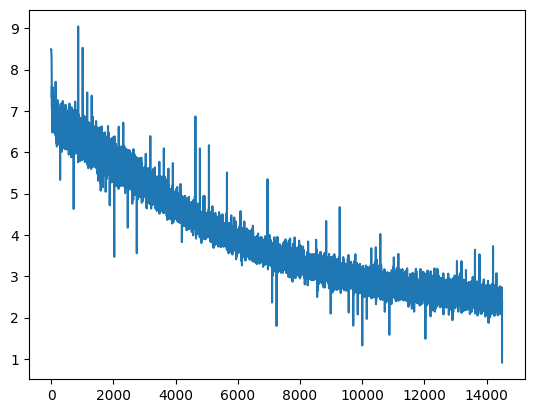

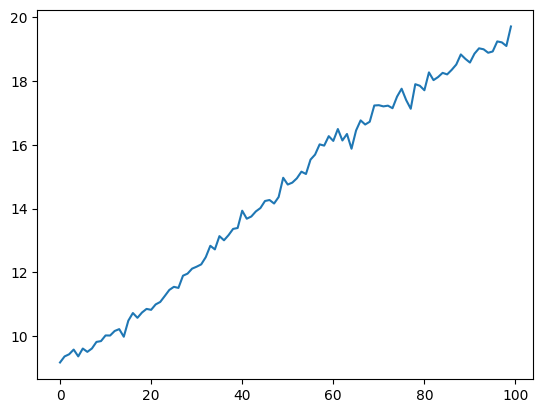

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tl)
plt.figure()
plt.plot(vl)

In [15]:
import torch.nn.functional as F
model = model1
def generate_sentence(model, start_sentence, max_length=20):
    model.eval()  # Ensure the model is in evaluation mode
    sentence = start_sentence
    words = sentence.split()
    with torch.no_grad():
        for _ in range(max_length):
            sentence_embedding = sentence_to_embedding(sentence).unsqueeze(0)
            output, attn_weights = model(sentence_embedding)
            predicted_word_idx = torch.argmax(output, dim=1).item()
            predicted_word = list(dataset.word_to_idx.keys())[list(dataset.word_to_idx.values()).index(predicted_word_idx)]
            sentence += " " + predicted_word
    return sentence

# Example usage after training
start_fragment = "The cat sat on the"
generated_sentence = generate_sentence(model, start_fragment)
#used_words = set(words)  # Keep track of words used in the sentence to apply penalties
print("Generated Sentence:", generated_sentence)

Generated Sentence: The cat sat on the night and the night the night of the night the night of the the wind of the wind of the


In [16]:

def generate_sentence2(model, start_sentence, max_length=20):
    model.eval()
    sentence = start_sentence
    words = set(start_sentence.split())
    with torch.no_grad():
        for _ in range(max_length):
            sentence_embedding = sentence_to_embedding(sentence).unsqueeze(0)
            output, attn_weights = model(sentence_embedding)
            logits = output.squeeze(0)
            
            # Penalize used words by setting their logits to a large negative value
            for word, idx in dataset.word_to_idx.items():
                if word in words:
                    logits[idx] = -float('Inf')

            predicted_word_idx = torch.argmax(logits).item()
            predicted_word = list(dataset.word_to_idx.keys())[list(dataset.word_to_idx.values()).index(predicted_word_idx)]
            if predicted_word not in words:  # Ensure not adding already used word (additional check)
                sentence += " " + predicted_word
                words.add(predicted_word)

    return sentence
generated_sentence2 = generate_sentence2(model, start_fragment)
print("Generated Sentence with Penalty:", generated_sentence2)

Generated Sentence with Penalty: The cat sat on the night and my family enemy, was too above of town. I man blue creature, which had unequal; with a transport


In [17]:
def top_k_sampling(logits, k=5):
    probabilities = F.softmax(logits, dim=0)  # Use dim=0 for 1D tensor
    top_k_probs, top_k_indices = torch.topk(probabilities, k)
    sampled_index = torch.multinomial(top_k_probs, 1).item()
    return top_k_indices[sampled_index].item()  # Return the index of the sampled word


import torch.nn.functional as F

def sample_with_temperature(logits, temperature=1.0):
    if temperature == 0:
        return torch.argmax(logits).item()  # Use torch.argmax without dim for 1D tensor
    probabilities = F.softmax(logits / temperature, dim=0)  # Use dim=0 for 1D tensor
    return torch.multinomial(probabilities, 1).item()  # sample from the distribution



def generate_sentence(model, start_sentence, max_length=50, strategy='top_k', k=5, temperature=1.0):
    model.eval()  # Ensure the model is in evaluation mode
    sentence = start_sentence
    words = sentence.split()
    used_words = set(words)  # Keep track of words to penalize repetitions
    generated_words = []

    with torch.no_grad():
        for _ in range(max_length):
            sentence_embedding = sentence_to_embedding(' '.join(words)).unsqueeze(0)  # Assume sentence_to_embedding is defined
            output, attn_weights = model(sentence_embedding)
            logits = output.squeeze(0)  # Assuming output shape is (1, vocab_size)

            # Penalize already used words
            for word, idx in dataset.word_to_idx.items():
                if word in used_words:
                    logits[idx] -= float('Inf')

            if strategy == 'temperature':
                predicted_word_idx = sample_with_temperature(logits, temperature)
            elif strategy == 'top_k':
                predicted_word_idx = top_k_sampling(logits, k)
            else:
                predicted_word_idx = torch.argmax(logits).item()  # Default to argmax if no valid strategy specified

            predicted_word = list(dataset.word_to_idx.keys())[list(dataset.word_to_idx.values()).index(predicted_word_idx)]
            if predicted_word in used_words:
                break  # Break if it loops back to a used word, preventing infinite loops
            words.append(predicted_word)
            used_words.add(predicted_word)
            generated_words.append(predicted_word)

    return ' '.join(words), generated_words

# Example usage:
start_fragment = "Frankenstein"
generated_sentence, generated_words = generate_sentence(model, start_fragment, strategy='temperature', k=5)
print("Generated Sentence:", generated_sentence)
print("Generated Words:", ' '.join(generated_words))
# now do the same for top_k
generated_sentence, generated_words = generate_sentence(model, start_fragment, strategy='top_k', k=5)
print("Generated Sentence:", generated_sentence)

Generated Sentence: Franenstein trees other almost well stock. the an sun of ice and pleasant believed alone over a with his hours town, had no were apparently at surely was in some two this years, that when I saw so dear as nearly months which it my father will been like up among
Generated Words: trees other almost well stock. the an sun of ice and pleasant believed alone over a with his hours town, had no were apparently at surely was in some two this years, that when I saw so dear as nearly months which it my father will been like up among
Generated Sentence: Franenstein endeavoured to intercept the vessel. and I could no thought, thy dear thirst for a father, rage with all my enemy, was too in which they here be unemployed by this one girl had been so on her mind more visit from calm of his child who not won an


In [18]:

# Example usage:
start_fragment = "Frankenstein"
generated_sentence, generated_words = generate_sentence(model, start_fragment, strategy='temperature', k=5)
print("Generated Sentence:", generated_sentence)
print("Generated Words:", ' '.join(generated_words))
# now do the same for top_k
generated_sentence, generated_words = generate_sentence(model, start_fragment, strategy='top_k', k=5)
print("Generated Sentence:", generated_sentence)

Generated Sentence: Frankenstein thus, Clerval, do not wish have make a tranquillity of an most which to the cold man and was own up with their ground eyes, could like that I had just sustained by his good were quickly on my dear but as he shall one hope from your union upon
Generated Words: thus, Clerval, do not wish have make a tranquillity of an most which to the cold man and was own up with their ground eyes, could like that I had just sustained by his good were quickly on my dear but as he shall one hope from your union upon
Generated Sentence: Frankenstein felt not be that I was acquainted to the coast of my father, and cries on a nook in her native avalanche or pleasant which with all had found been passed from his eyes, she gave me by this night as it more at our scene for an dream, near


In [21]:

def beam_search(model, start_sentence, beam_width=3, max_length=20, repetition_penalty=1.2):
    model.eval()
    start_words = start_sentence.split()
    
    # Initial beam of start words with log-probability of 0
    beams = [(start_words, 0.0)]
    
    # Perform beam search
    with torch.no_grad():
        for _ in range(max_length - len(start_words)):
            new_beams = []
            for words, score in beams:
                # Convert current beam's words to embeddings and pass through the model
                sentence_embedding = sentence_to_embedding(' '.join(words)).unsqueeze(0)
                output, attn_weights = model(sentence_embedding)
                log_probs = F.log_softmax(output, dim=1).squeeze(0)  # Assuming output shape is (1, vocab_size)

                # Apply repetition penalty
                for i in range(len(log_probs)):
                    word = list(dataset.word_to_idx.keys())[list(dataset.word_to_idx.values()).index(i)]
                    if word in words:
                        log_probs[i] -= repetition_penalty

                # Consider the top beam_width possibilities for extending the beam
                top_log_probs, top_indices = torch.topk(log_probs, beam_width)
                
                # Create new beams from the old beam
                for log_prob, idx in zip(top_log_probs, top_indices):
                    new_word = list(dataset.word_to_idx.keys())[list(dataset.word_to_idx.values()).index(idx.item())]
                    new_beam = (words + [new_word], score + log_prob.item())
                    new_beams.append(new_beam)

            # Sort all new beams by their scores in decreasing order and keep the best beam_width beams
            beams = sorted(new_beams, key=lambda b: b[1], reverse=True)[:beam_width]

    # Choose the beam with the highest score
    best_words, best_score = max(beams, key=lambda b: b[1])
    return ' '.join(best_words), best_score

            


# Example usage
start_fragment = "Frankenstein"
generated_sentence, score = beam_search(model, start_fragment, beam_width=5, max_length=30, repetition_penalty=0)
print("Generated Sentence:", generated_sentence)
print("Score of the best sequence:", score)

Generated Sentence: Frankenstein endeavoured to quit the execution of the same man man stars, and was to be been content of the night and arranging the snow and pleasant and and the
Score of the best sequence: -48.23701550066471
